In [1]:
# Import useful libraries

import warnings
warnings.filterwarnings('ignore')
import time
import re
import string
from numpy import mean
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.utils.multiclass import type_of_target
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


In [2]:
# Read dataset

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.columns = train_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [3]:
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)
train_data.head()

Train Data Shape:  (381109, 12)
Test Data Shape:  (127037, 11)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train_data.isnull().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

# Exploratory Data Analysis

In [5]:
train_data['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

In [6]:
train_data.nunique()

id                      381109
gender                       2
age                         66
driving_license              2
region_code                 53
previously_insured           2
vehicle_age                  3
vehicle_damage               2
annual_premium           48838
policy_sales_channel       155
vintage                    290
response                     2
dtype: int64

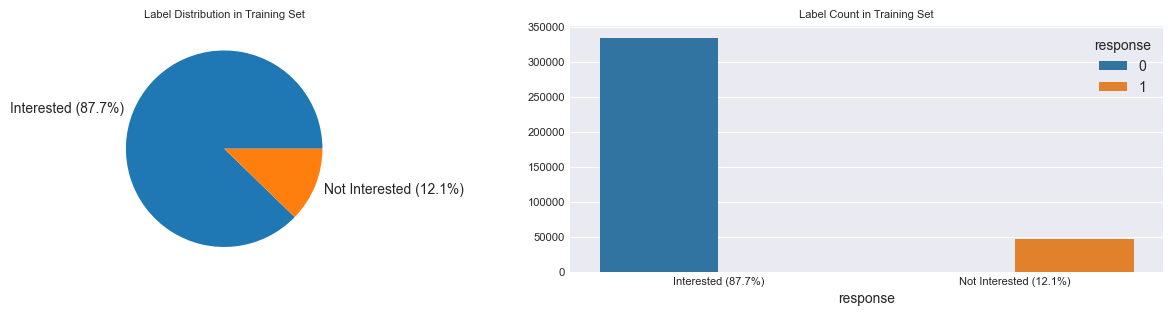

In [7]:
fig, axes = plt.subplots(ncols = 2, figsize = (13, 3), dpi = 100)
plt.tight_layout()

train_data.groupby('response').count()['id'].plot(kind = 'pie', ax = axes[0], labels = ['Interested (87.7%)', 'Not Interested (12.1%)'])
sns.countplot(x = train_data['response'], hue = train_data['response'], ax = axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Interested (87.7%)', 'Not Interested (12.1%)'])
axes[0].tick_params(axis = 'x', labelsize = 8)
axes[0].tick_params(axis = 'y', labelsize = 8)
axes[1].tick_params(axis = 'x', labelsize = 8)
axes[1].tick_params(axis = 'y', labelsize = 8)

axes[0].set_title('Label Distribution in Training Set', fontsize = 8)
axes[1].set_title('Label Count in Training Set', fontsize =8)

plt.show()

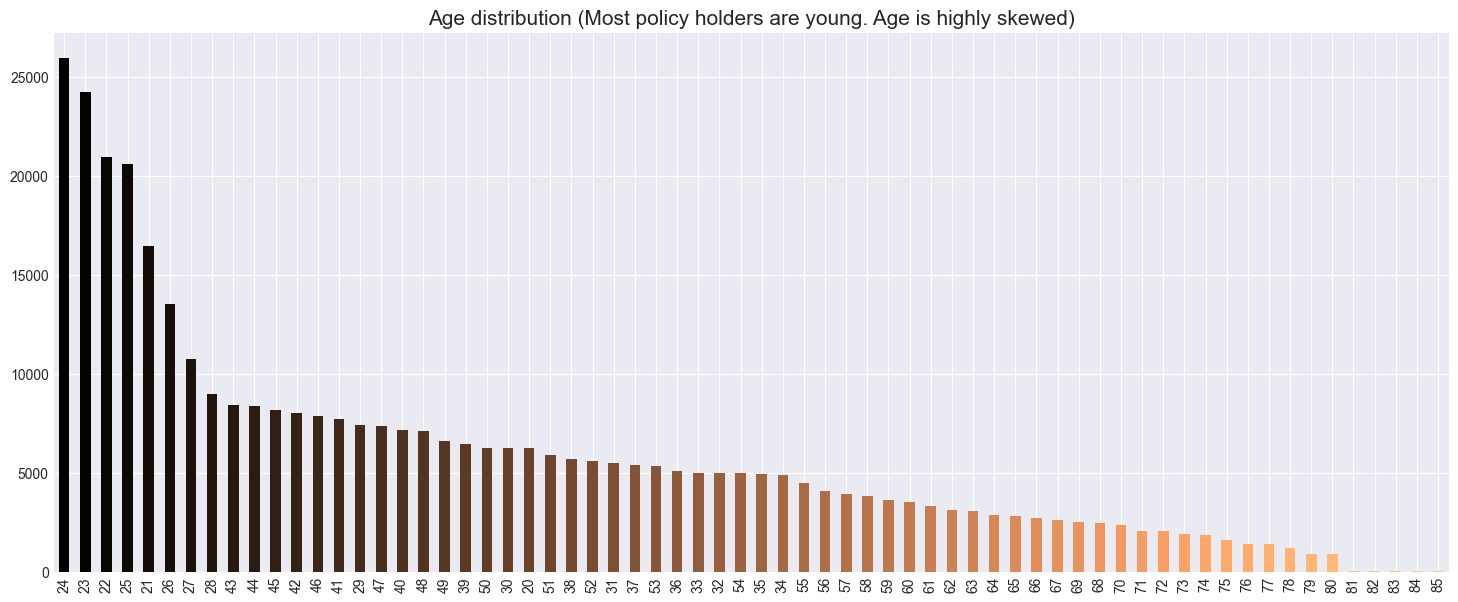

In [8]:
# looking at the frequency of records by age

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 66))
train_data['age'].value_counts().head(66).plot.bar(color = color)
plt.title('Age distribution (Most policy holders are young. Age is highly skewed)', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

## Combine Training and Test Data for additional visualizations

In [9]:
train_data['type'] = 'train'
test_data['type'] = 'test'

master_data = pd.concat([train_data, test_data])

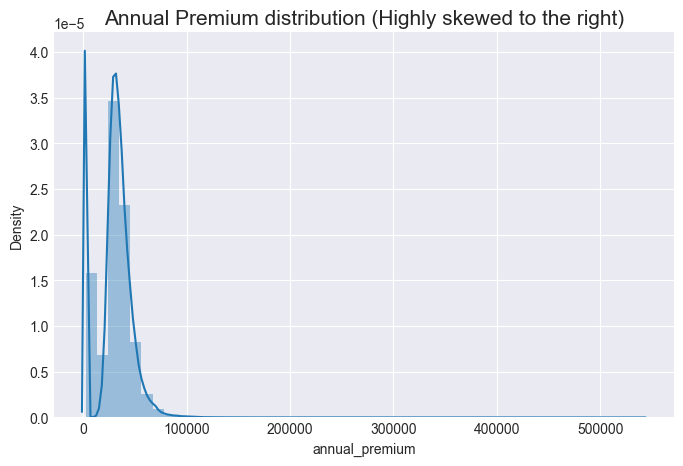

In [10]:
plt.figure(figsize = (8, 5))
sns.distplot(master_data['annual_premium'])
plt.title('Annual Premium distribution (Highly skewed to the right)', fontsize = 15)
plt.show()

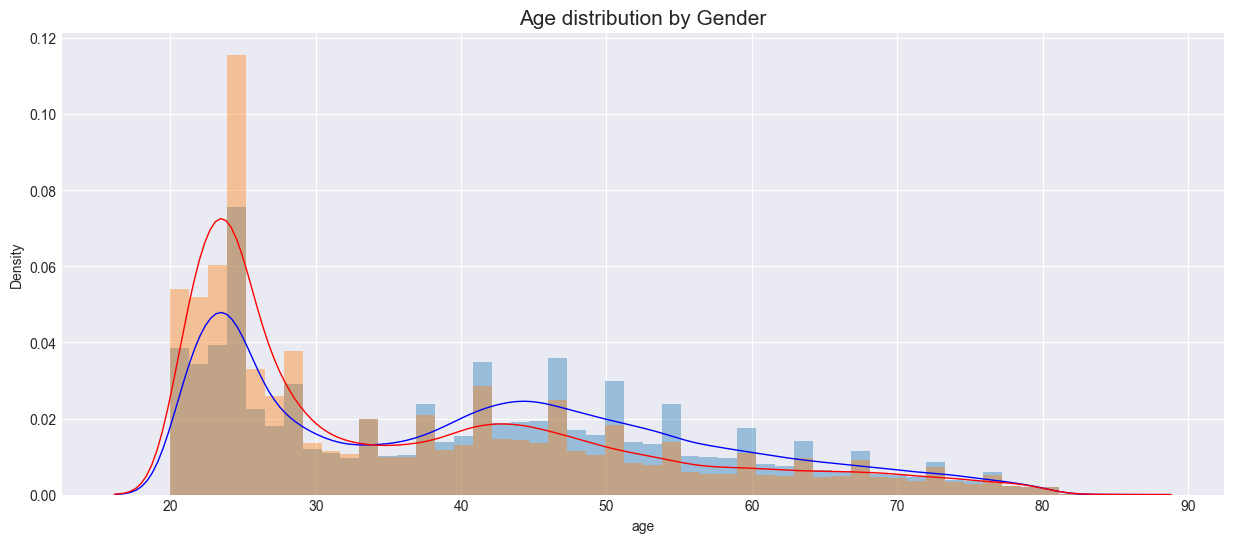

In [11]:
plt.figure(figsize = (15, 6))
sns.distplot(master_data.loc[(master_data['gender'] == 'Male'), 'age'], kde_kws = {"color": "b", "lw": 1, "label": "Male"})
sns.distplot(master_data.loc[(master_data['gender'] == 'Female'), 'age'], kde_kws = {"color": "r", "lw": 1, "label": "Female"})
plt.title('Age distribution by Gender', fontsize = 15)
plt.show()

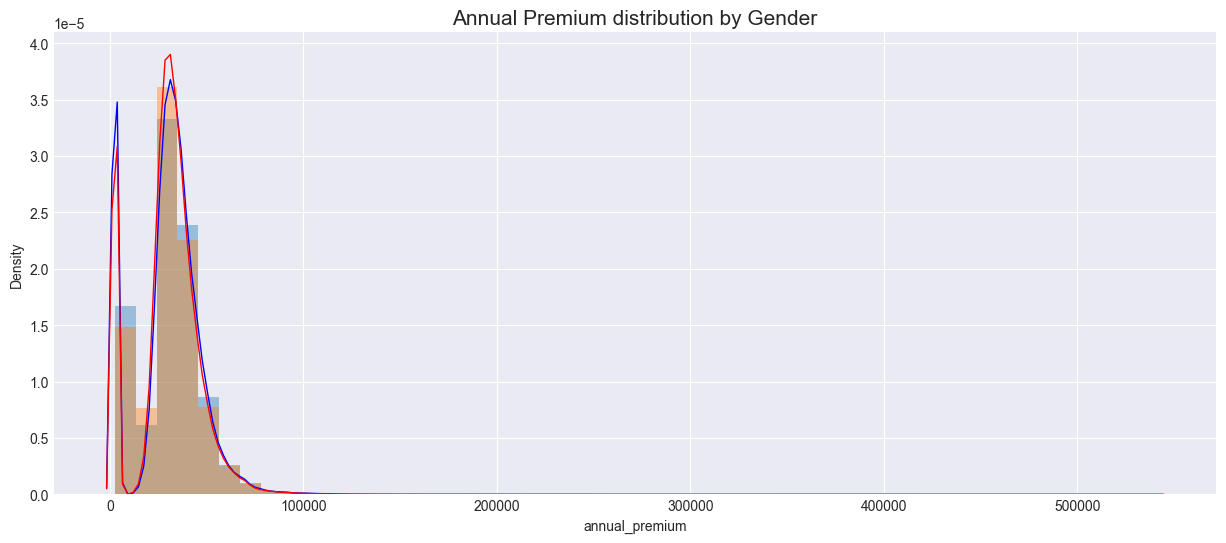

In [12]:
plt.figure(figsize = (15, 6))
sns.distplot(master_data.loc[(master_data['gender'] == 'Male'), 'annual_premium'], kde_kws = {"color": "b", "lw": 1, "label": "Male"})
sns.distplot(master_data.loc[(master_data['gender'] == 'Female'), 'annual_premium'], kde_kws = {"color": "r", "lw": 1, "label": "Female"})
plt.title('Annual Premium distribution by Gender', fontsize = 15)
plt.show()

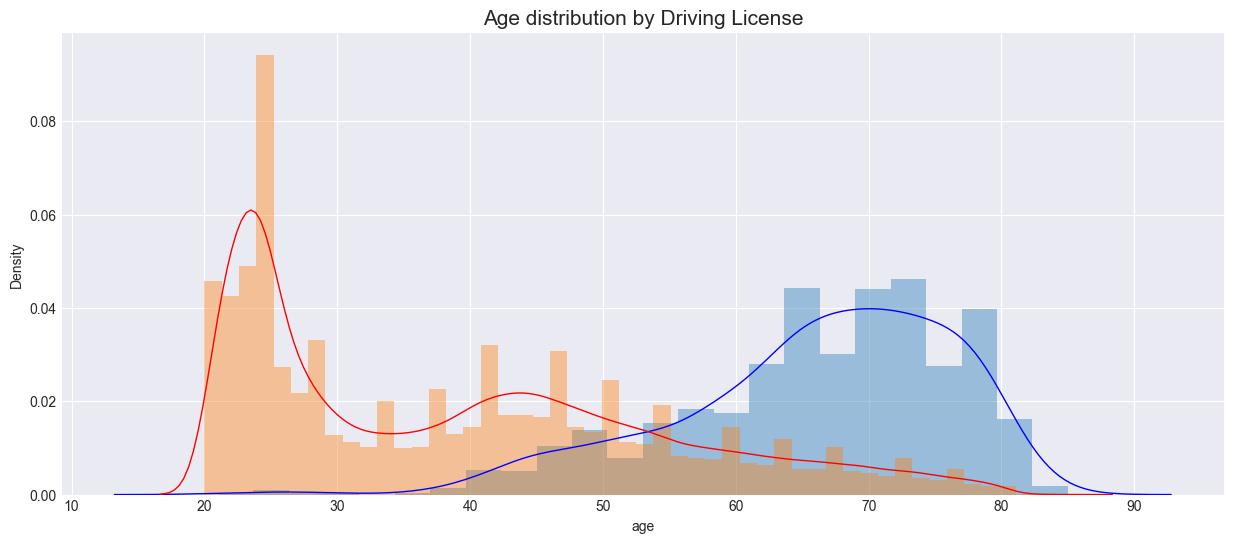

In [13]:
plt.figure(figsize = (15, 6))
sns.distplot(master_data.loc[(master_data['driving_license'] == 0), 'age'], kde_kws = {"color": "b", "lw": 1, "label": "Not Licensed for driving"})
sns.distplot(master_data.loc[(master_data['driving_license'] == 1), 'age'], kde_kws = {"color": "r", "lw": 1, "label": "Licensed for Driving"})
plt.title('Age distribution by Driving License', fontsize = 15)
plt.show()

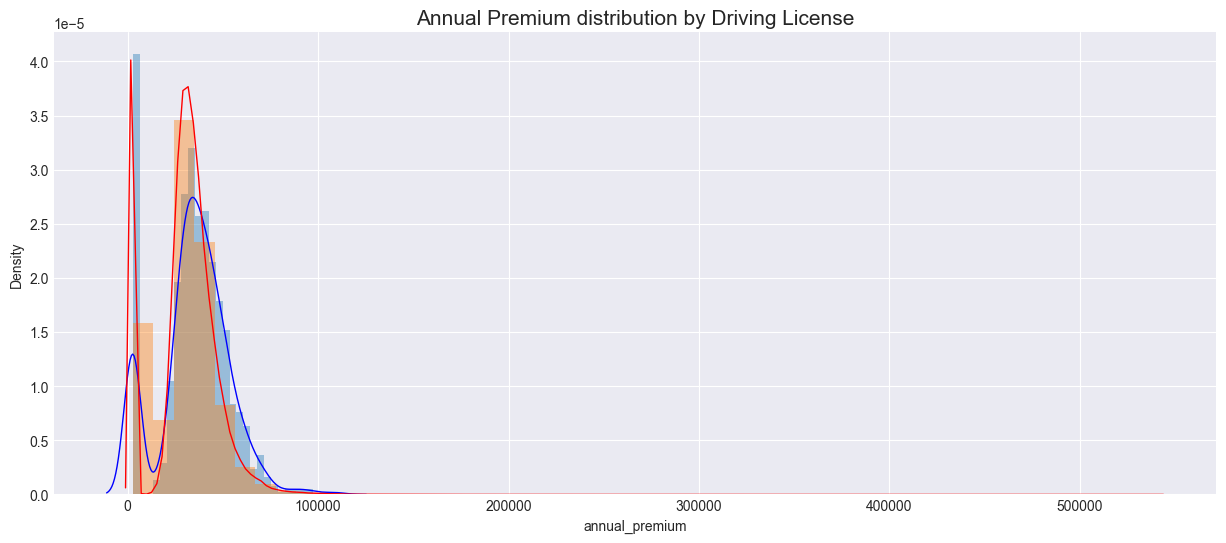

In [14]:
plt.figure(figsize = (15, 6))
sns.distplot(master_data.loc[(master_data['driving_license'] == 0), 'annual_premium'], kde_kws = {"color": "b", "lw": 1, "label": "Not Licensed for driving"})
sns.distplot(master_data.loc[(master_data['driving_license'] == 1), 'annual_premium'], kde_kws = {"color": "r", "lw": 1, "label": "Licensed for Driving"})
plt.title('Annual Premium distribution by Driving License', fontsize = 15)
plt.show()

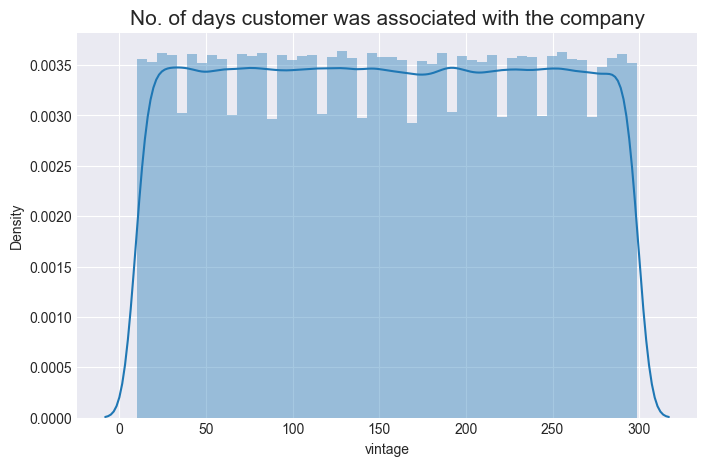

In [15]:
plt.figure(figsize = (8, 5))
sns.distplot(master_data['vintage'])
plt.title('No. of days customer was associated with the company', fontsize = 15)
plt.show()

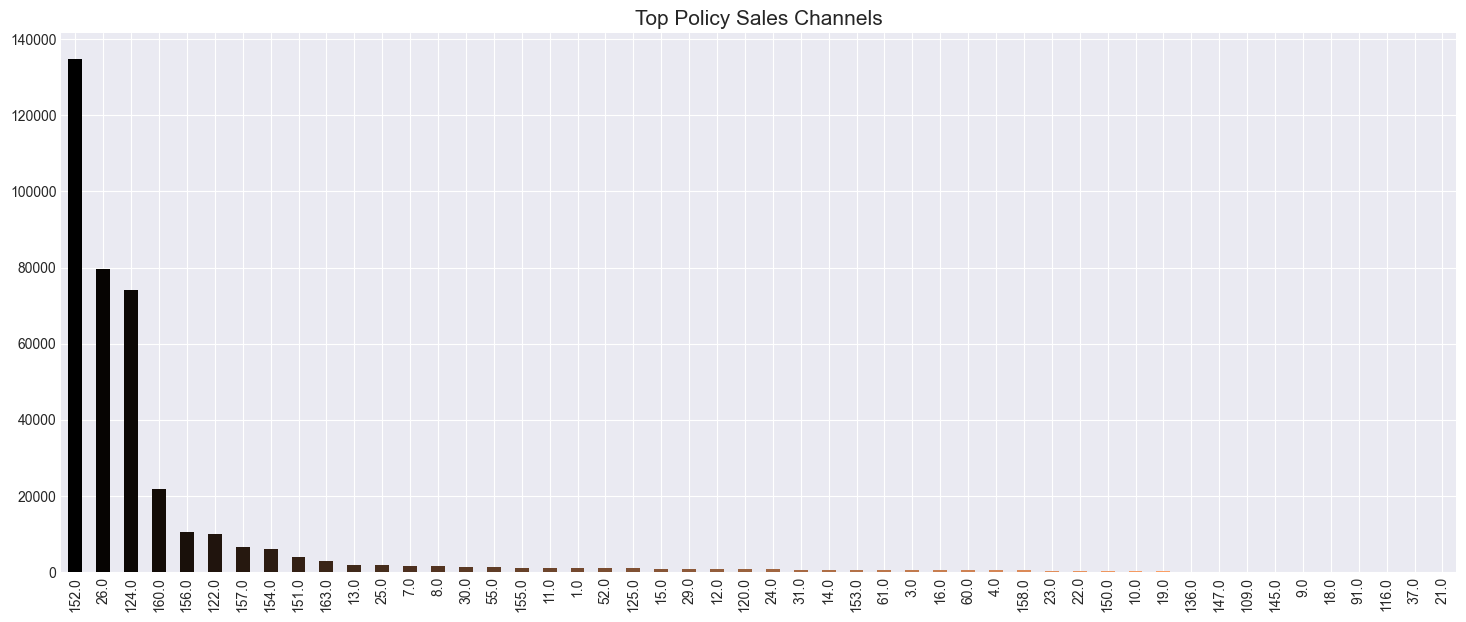

In [16]:
# looking at the frequency of records by age

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 50))
train_data['policy_sales_channel'].value_counts().head(50).plot.bar(color = color)
plt.title('Top Policy Sales Channels', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

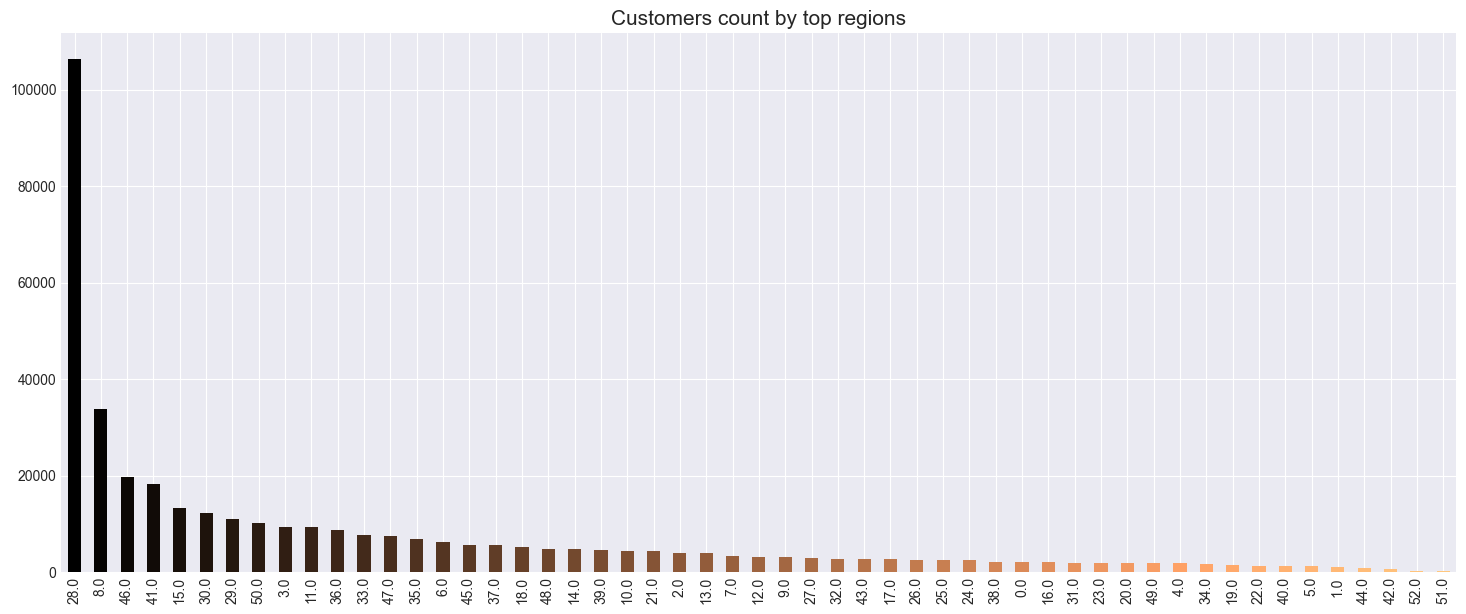

In [17]:
# looking at the frequency of records by sales channel

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 53))
train_data['region_code'].value_counts().head(53).plot.bar(color = color)
plt.title('Customers count by top regions', fontsize = 15)
plt.xticks(rotation = 90)
plt.show()

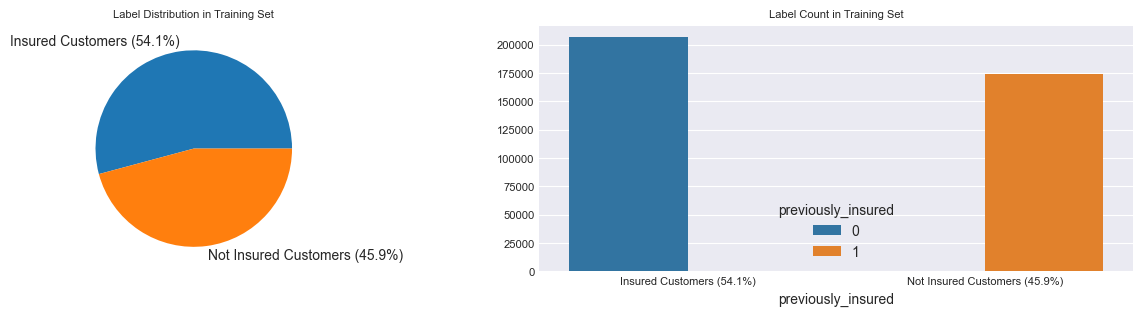

In [18]:
fig, axes = plt.subplots(ncols = 2, figsize = (13, 3), dpi = 100)
plt.tight_layout()

train_data.groupby('previously_insured').count()['id'].plot(kind = 'pie', ax = axes[0], labels = ['Insured Customers (54.1%)', 'Not Insured Customers (45.9%)'])
sns.countplot(x = train_data['previously_insured'], hue = train_data['previously_insured'], ax = axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Insured Customers (54.1%)', 'Not Insured Customers (45.9%)'])
axes[0].tick_params(axis = 'x', labelsize = 8)
axes[0].tick_params(axis = 'y', labelsize = 8)
axes[1].tick_params(axis = 'x', labelsize = 8)
axes[1].tick_params(axis = 'y', labelsize = 8)

axes[0].set_title('Label Distribution in Training Set', fontsize = 8)
axes[1].set_title('Label Count in Training Set', fontsize =8)

plt.show()

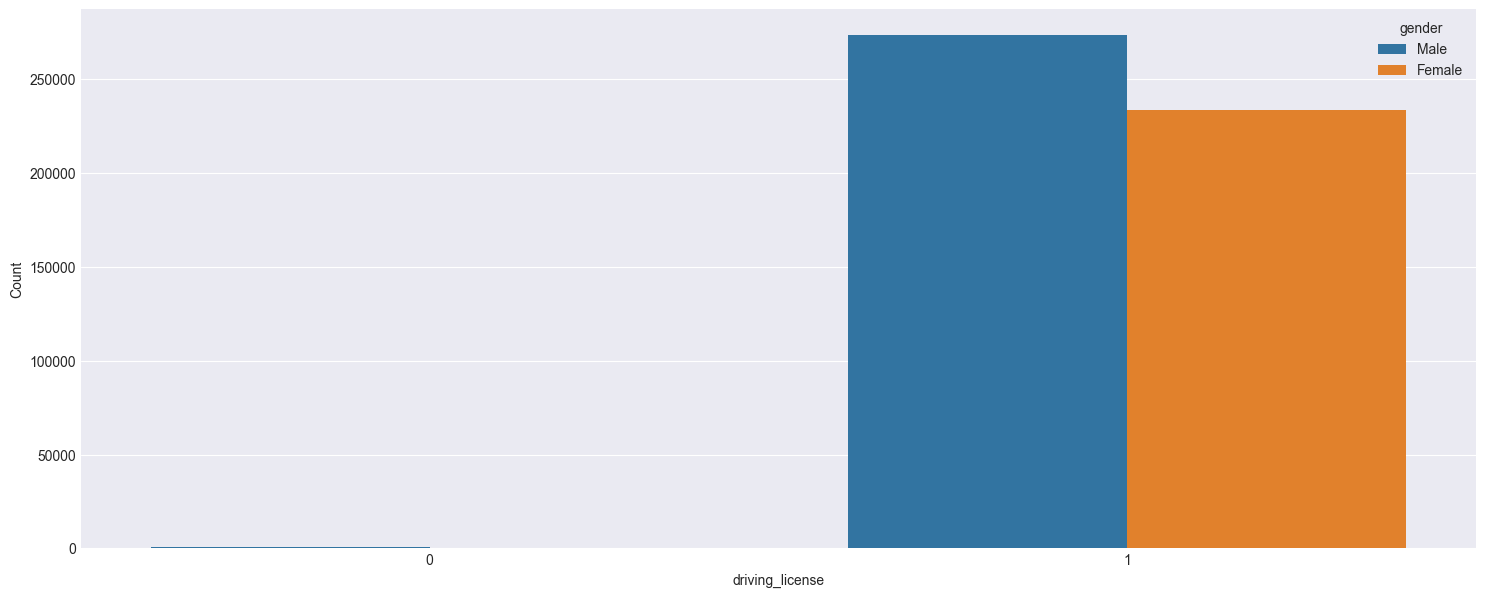

In [19]:
sns.countplot(data = master_data, x = 'driving_license', hue = 'gender')
plt.ylabel('Count')
plt.show()

##### We should oversample the minority class to account for customers without a driving license

# Feature Engineering

In [20]:
# Unique values for all the columns
for col in train_data.columns[~(train_data.columns.isin(['age', 'id', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage']))].tolist():
    print(" Unique Values --> " + col, ':', len(train_data[col].unique()), ': ', train_data[col].unique())

 Unique Values --> gender : 2 :  ['Male' 'Female']
 Unique Values --> driving_license : 2 :  [1 0]
 Unique Values --> previously_insured : 2 :  [0 1]
 Unique Values --> vehicle_age : 3 :  ['> 2 Years' '1-2 Year' '< 1 Year']
 Unique Values --> vehicle_damage : 2 :  ['Yes' 'No']
 Unique Values --> response : 2 :  [1 0]
 Unique Values --> type : 1 :  ['train']


In [21]:
gender = {'Male': 0, 'Female': 1}
driving_license = {0: 0, 1: 1}
previously_insured = {0: 1, 1: 0}
vehicle_age = {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}
vehicle_damage = {'Yes': 1, 'No': 0}

master_data['gender'] = master_data['gender'].map(gender)
master_data['driving_license'] = master_data['driving_license'].map(driving_license)
master_data['previously_insured'] = master_data['previously_insured'].map(previously_insured)
master_data['vehicle_age'] = master_data['vehicle_age'].map(vehicle_age)
master_data['vehicle_damage'] = master_data['vehicle_damage'].map(vehicle_damage)

master_data['policy_sales_channel'] = master_data['policy_sales_channel'].apply(lambda x: np.int32(x))
master_data['region_code'] = master_data['region_code'].apply(lambda x: np.int32(x))

master_data.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,type
0,1,0,44,1,28,1,2,1,40454.0,26,217,1.0,train
1,2,0,76,1,3,1,1,0,33536.0,26,183,0.0,train
2,3,0,47,1,28,1,2,1,38294.0,26,27,1.0,train
3,4,0,21,1,11,0,0,0,28619.0,152,203,0.0,train
4,5,1,29,1,41,0,0,0,27496.0,152,39,0.0,train


# Correlation of features with target variable

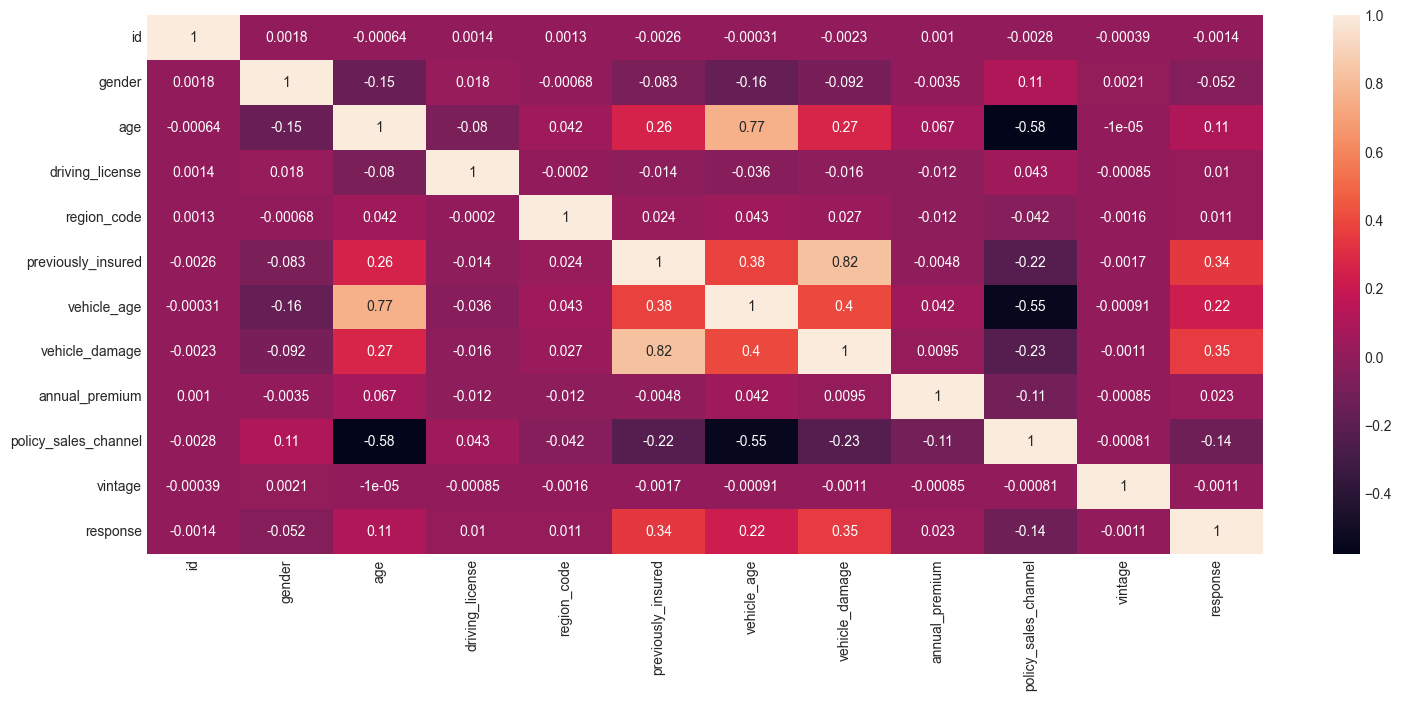

In [22]:
corrMatrix = master_data.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

- It appears **policy sales channel** and **vintage** are more negatively correlated to the target variable **response**

In [23]:
# Numerical columns
numerical_cols = ['age', 'vintage']

# categorical column 
cat_col = ['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel']

#master_data['policy_sales_channel'] = master_data['policy_sales_channel'].map(master_data['policy_sales_channel'].value_counts())
#master_data['region_code'] = master_data['region_code'].map(master_data['region_code'].value_counts())

ss = StandardScaler()
master_data[numerical_cols] = ss.fit_transform(master_data[numerical_cols])

mm = MinMaxScaler()
master_data[['annual_premium']] = mm.fit_transform(master_data[['annual_premium']])

master_data.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,type
0,1,0,0.334938,1,28,1,2,1,0.070366,26,0.748905,1.0,train
1,2,0,2.399432,1,3,1,1,0,0.057496,26,0.342540,0.0,train
2,3,0,0.528484,1,28,1,2,1,0.066347,26,-1.521956,1.0,train
3,4,0,-1.148918,1,11,0,0,0,0.048348,152,0.581578,0.0,train
4,5,1,-0.632794,1,41,0,0,0,0.046259,152,-1.378534,0.0,train


## Splitting bact to train/test set

In [24]:
train_data = master_data.loc[(master_data['type'] == 'train')]
test_data = master_data.loc[(master_data['type'] == 'test')]

train_data = train_data.drop(['id', 'type'], axis = 1)
train_data['response'] = train_data['response'].apply(lambda x: np.int32(x))

testIDs = test_data['id']
test_data = test_data.drop(['id', 'type', 'response'], axis = 1)
train_data.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,0,0.334938,1,28,1,2,1,0.070366,26,0.748905,1
1,0,2.399432,1,3,1,1,0,0.057496,26,0.342540,0
2,0,0.528484,1,28,1,2,1,0.066347,26,-1.521956,1
3,0,-1.148918,1,11,0,0,0,0.048348,152,0.581578,0
4,1,-0.632794,1,41,0,0,0,0.046259,152,-1.378534,0


In [25]:
for column in cat_col:
    test_data[column] = test_data[column].astype('str')

In [26]:
for column in cat_col:
    train_data[column] = train_data[column].astype('str')

train_data = train_data.drop(['vintage'], axis = 1)
test_data = test_data.drop(['vintage'], axis = 1)

X = train_data.drop(['response'], axis = 1)#.values
y = train_data['response']#.values

cat_cols = [0, 2, 3, 4, 5, 6, 8]

# Model Building-LGBM Classifier with KFold

In [27]:
X = train_data.drop(['response'], axis = 1).values
y = train_data['response'].values

In [28]:
kfold, scores = KFold(n_splits = 5, shuffle = True, random_state = 22), list()
for train, test in kfold.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    model = LGBMClassifier(random_state = 22, max_depth = 7, n_estimators = 110, reg_lambda = 1.2, reg_alpha = 1.2, min_child_weight = 1, 
                           learning_rate = 0.15, colsample_bytree = 0.5)
    model.fit(X_train, y_train)
    preds = [pred[1] for pred in model.predict_proba(X_test)]
    score = roc_auc_score(y_test, preds, average = 'weighted')
    scores.append(score)
    print('Validation ROC AUC:', score)
print("Average Validation ROC AUC: ", sum(scores)/len(scores))

Validation ROC AUC: 0.8569038520889919
Validation ROC AUC: 0.8582576681090892
Validation ROC AUC: 0.8580198851705519
Validation ROC AUC: 0.8604038000552066
Validation ROC AUC: 0.8597415304460303
Average Validation ROC AUC:  0.858665347173974


## ROC AUC Curve

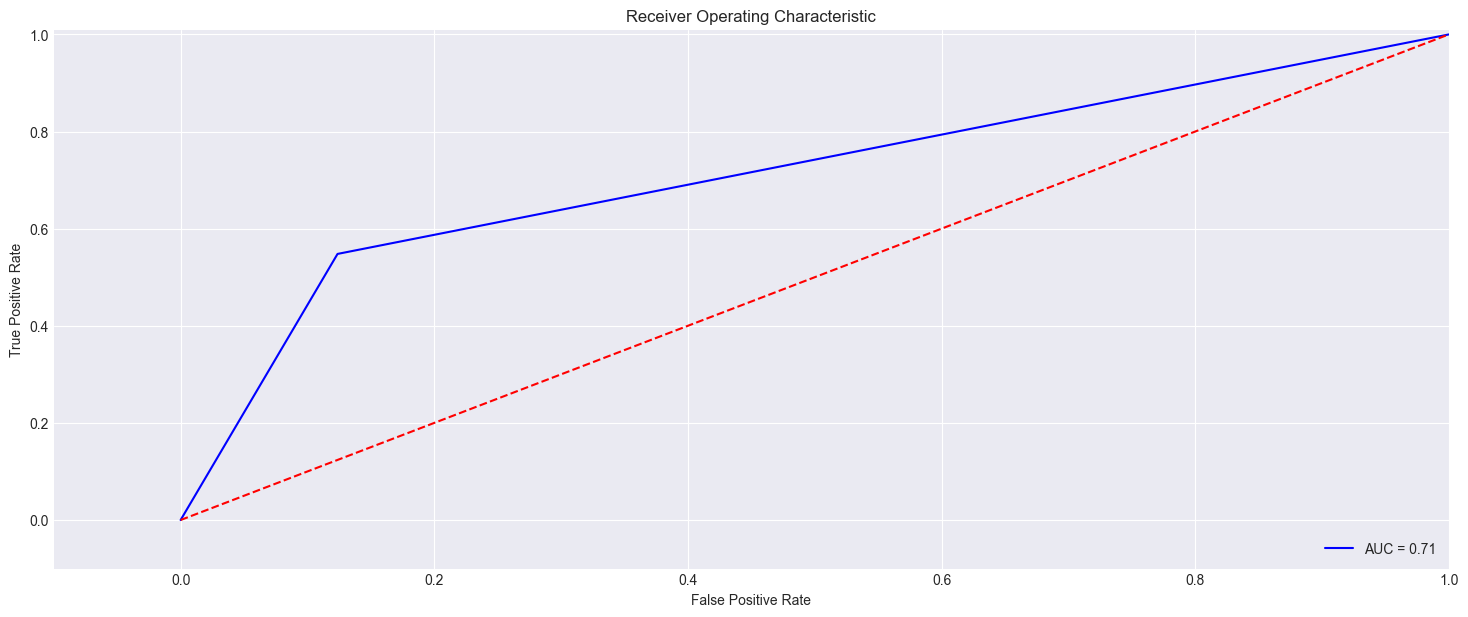

In [29]:
yTest = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(yTest.ravel(), y_test)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Splitting the dataset

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 22)

## Hyperparameter Tuning

In [31]:

model = LGBMClassifier(random_state = 22)

param_grid = {"learning_rate"    : [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40],
              "max_depth"        : [4, 5, 6, 7, 8, 9, 10],
              "min_child_weight" : [1, 3, 5, 7],
              "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
              "colsample_bytree" : [0.3, 0.4, 0.5 , 0.7],
              "n_estimators"     : [50, 70, 90, 100, 120, 150, 200, 250, 300, 350, 400, 450],
              'reg_alpha'        : [1,1.2],
              'reg_lambda'       : [1,1.2,1.4]
              }

kfold = KFold(n_splits = 6, shuffle = True, random_state = 22)

grid_search = RandomizedSearchCV(model, param_distributions = param_grid, scoring = "accuracy", n_jobs  = -1, cv = kfold, verbose = 1)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 6 folds for each of 10 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: gamma
Best: 0.877463 using {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.3}


---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     83632
           1       0.52      0.02      0.04     11646

    accuracy                           0.88     95278
   macro avg       0.70      0.51      0.49     95278
weighted avg       0.84      0.88      0.83     95278

---------------------------------------------------------
Accuracy:0.8572944125184755
---------------------------------------------------------


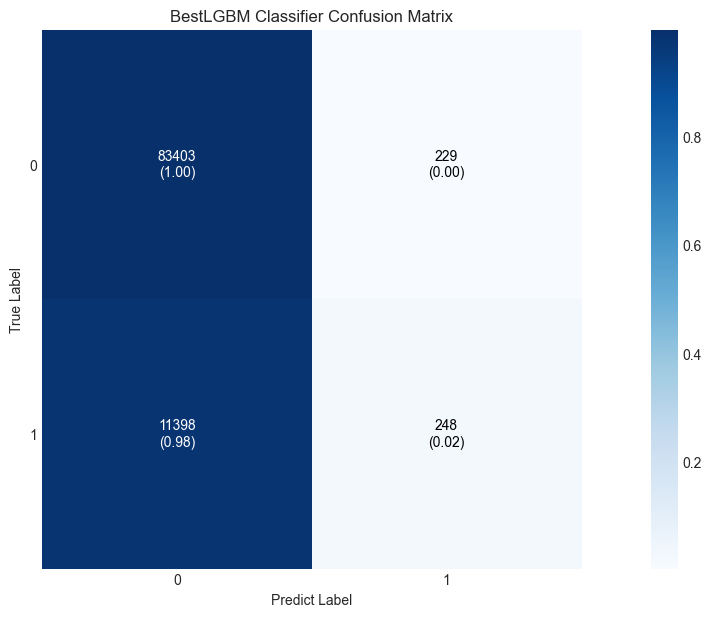

In [32]:
bestLGB = LGBMClassifier(random_state = 2023, max_depth = 9, n_estimators = 200, reg_lambda = 1.4, reg_alpha = 1, min_child_weight = 1,
                         learning_rate = 0.1,  colsample_bytree = 0.5)
bestLGB.fit(X_train, y_train)
y_pred = bestLGB.predict_proba(X_test)

print('---------------------------------------------------------')
print(classification_report(y_test,bestLGB.predict(X_test)))
print('---------------------------------------------------------')
print('Accuracy:'+str(roc_auc_score(y_test,bestLGB.predict_proba(X_test)[:, 1])))
print('---------------------------------------------------------')
y_pred=bestLGB.predict(X_test)
conf=confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf,colorbar=True,show_normed=True)
plt.title("BestLGBM Classifier Confusion Matrix")
plt.xlabel("Predict Label")
plt.ylabel("True Label")
plt.show()  